In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft2, fftshift, ifft2

rng = np.random.RandomState(42)


In [2]:
def gaussian_psf(size, sigma):
    """
    Generates a 2D Gaussian kernel.

    Parameters:
        size (int): Kernel size (must be odd for symmetry).
        sigma (float): Standard deviation of the Gaussian.

    Returns:
        np.ndarray: Normalized 2D Gaussian kernel.
    """
    ax = np.arange(-(size // 2), size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)  # Normalize to ensure sum = 1

In [35]:
noise_rate = 50.0
snr = 30  # 3 ~ 1.7, 10 ~ 6
img_size = (128, 128)
psf_size = 9
sigma = 0.5

psf_kernel = gaussian_psf(psf_size, sigma)

y0a, x0a = 40, 40
y1a, x1a = 70, 70
target_signal0a = rng.poisson(snr * np.sqrt(noise_rate)) * psf_kernel
target_signal1a = rng.poisson(snr * np.sqrt(noise_rate)) * psf_kernel

image0 = rng.poisson(noise_rate, img_size).astype(float)
image0[
    x0a - psf_size // 2 : x0a + psf_size // 2 + 1,
    y0a - psf_size // 2 : y0a + psf_size // 2 + 1,
] += target_signal0a

image1 = rng.poisson(noise_rate, img_size).astype(float)
image1[
    x1a - psf_size // 2 : x1a + psf_size // 2 + 1,
    y1a - psf_size // 2 : y1a + psf_size // 2 + 1,
] += target_signal1a


y0b, x0b = 60, 60
y1b, x1b = 90, 90
target_signal0b = rng.poisson(snr * np.sqrt(noise_rate)) * psf_kernel
target_signal1b = rng.poisson(snr * np.sqrt(noise_rate)) * psf_kernel

image0[
    x0b - psf_size // 2 : x0b + psf_size // 2 + 1,
    y0b - psf_size // 2 : y0b + psf_size // 2 + 1,
] += target_signal0b

image1[
    x1b - psf_size // 2 : x1b + psf_size // 2 + 1,
    y1b - psf_size // 2 : y1b + psf_size // 2 + 1,
] += target_signal1b

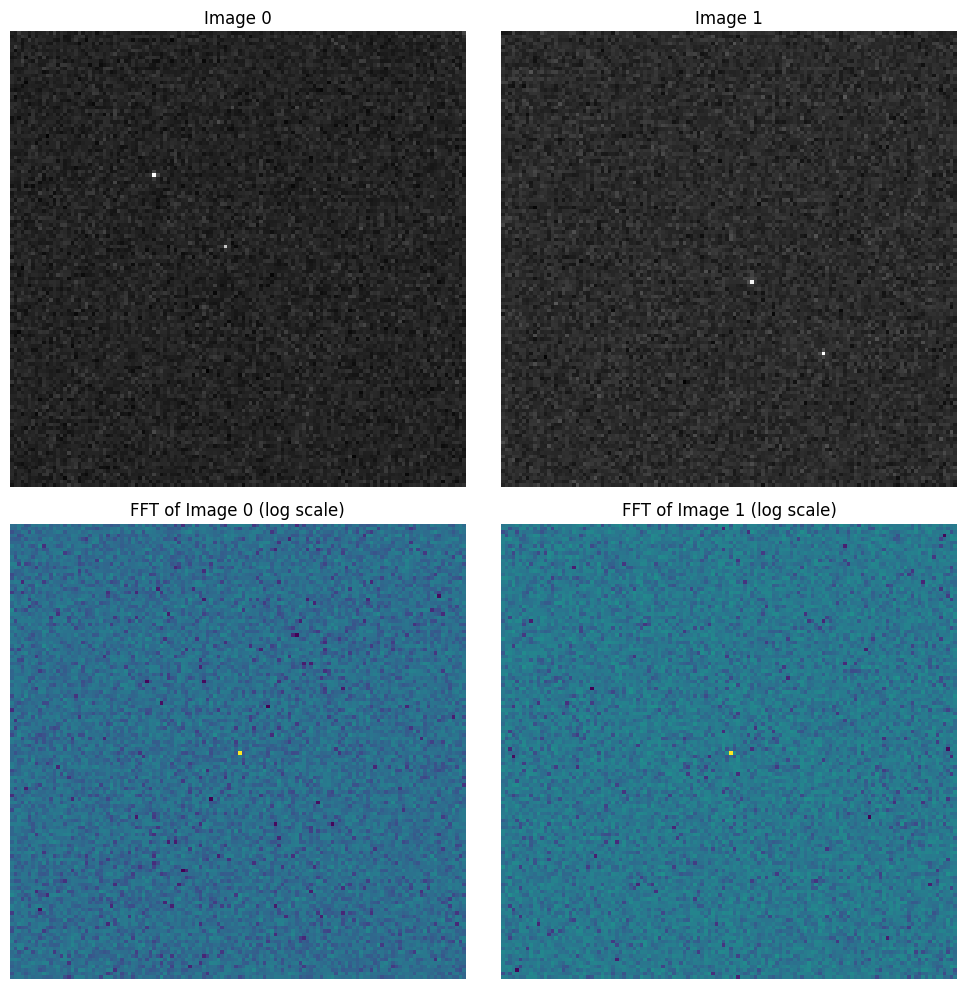

In [36]:
# pad to increase resolution
image0_padded = np.pad(image0, 0, mode="constant", constant_values=(0))
image1_padded = np.pad(image1, 0, mode="constant", constant_values=(0))

# Compute the Fourier transforms of the images
fft_image0 = fft2(image0_padded)
fft_image1 = fft2(image1_padded)

# Shift zero-frequency component to the center for visualization
fft_image0_shifted = fftshift(np.abs(fft_image0))
fft_image1_shifted = fftshift(np.abs(fft_image1))

# Plot the original images and their Fourier transforms
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Original images
axs[0, 0].imshow(image0, cmap="gray")
axs[0, 0].set_title("Image 0")
axs[0, 1].imshow(image1, cmap="gray")
axs[0, 1].set_title("Image 1")

# Fourier transforms
axs[1, 0].imshow(np.log1p(fft_image0_shifted), cmap="viridis")
axs[1, 0].set_title("FFT of Image 0 (log scale)")
axs[1, 1].imshow(np.log1p(fft_image1_shifted), cmap="viridis")
axs[1, 1].set_title("FFT of Image 1 (log scale)")

# Clean up plot
for ax in axs.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()


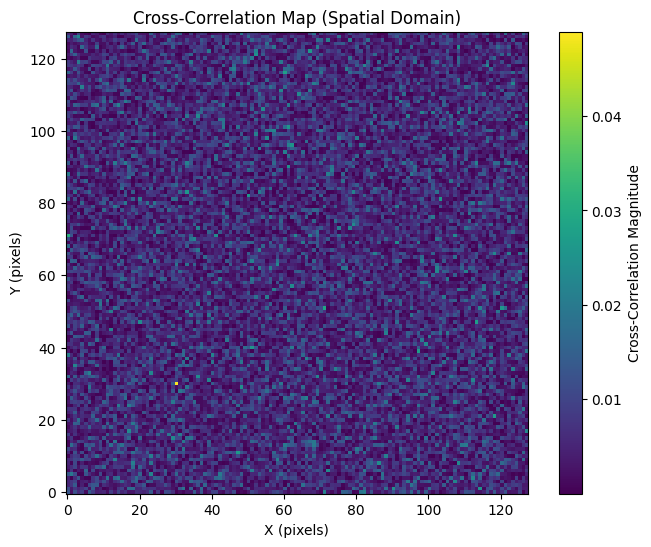

In [37]:
# Compute the cross-power spectrum
cross_power_spectrum = fft_image1 * np.conj(fft_image0)
# Normalize the cross-power spectrum
epsilon = 1e-8  # Small value to prevent division by zero
cross_power_spectrum_normalized = cross_power_spectrum / (
    np.abs(cross_power_spectrum) + epsilon
)

# Compute the inverse Fourier transform to get the cross-correlation map
cross_correlation = ifft2(cross_power_spectrum_normalized)

# Take the absolute value since the result may have a small imaginary component due to numerical precision
cross_correlation_real = np.abs(cross_correlation)

# Visualize the cross-correlation map
plt.figure(figsize=(8, 6))
plt.imshow(cross_correlation_real, cmap="viridis", origin="lower")
plt.colorbar(label="Cross-Correlation Magnitude")
plt.title("Cross-Correlation Map (Spatial Domain)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.show()


In [38]:
# Locate the peak of the cross-correlation map
peak_coords = np.unravel_index(
    np.argmax(cross_correlation_real), cross_correlation_real.shape
)

# Calculate the shift in pixels
shift_x = peak_coords[1]  # Horizontal shift (columns)
shift_y = peak_coords[0]  # Vertical shift (rows)

# Adjust for wrap-around shifts (if the peak is near the edges of the map)
if shift_x > cross_correlation_real.shape[1] // 2:
    shift_x -= cross_correlation_real.shape[1]

if shift_y > cross_correlation_real.shape[0] // 2:
    shift_y -= cross_correlation_real.shape[0]

# Print the results
print(f"Peak Coordinates: {peak_coords}")
print(f"Estimated Shift: Δx = {shift_x} pixels, Δy = {shift_y} pixels")


Peak Coordinates: (np.int64(30), np.int64(30))
Estimated Shift: Δx = 30 pixels, Δy = 30 pixels


In [7]:
def subpixel_peak(cross_corr, peak_coords):
    """
    Refine the peak location in the cross-correlation map using quadratic interpolation.

    Parameters:
        cross_corr (np.ndarray): Cross-correlation map.
        peak_coords (tuple): Integer coordinates of the peak (row, col).

    Returns:
        tuple: Subpixel refined peak coordinates (y, x).
    """
    y, x = peak_coords

    # Ensure the peak is not on the edge of the image
    if y <= 0 or y >= cross_corr.shape[0] - 1 or x <= 0 or x >= cross_corr.shape[1] - 1:
        return float(y), float(x)  # Can't interpolate, return integer peak

    # Extract neighboring values for interpolation
    f_yx = cross_corr[y, x]
    f_y1x = cross_corr[y - 1, x]
    f_y2x = cross_corr[y + 1, x]
    f_yx1 = cross_corr[y, x - 1]
    f_yx2 = cross_corr[y, x + 1]

    # Quadratic interpolation in the y-direction
    delta_y = 0.5 * (f_y1x - f_y2x) / (f_y1x - 2 * f_yx + f_y2x)

    # Quadratic interpolation in the x-direction
    delta_x = 0.5 * (f_yx1 - f_yx2) / (f_yx1 - 2 * f_yx + f_yx2)

    # Return subpixel peak coordinates
    return y + delta_y, x + delta_x

In [8]:
# Locate the integer peak
peak_coords = np.unravel_index(
    np.argmax(cross_correlation_real), cross_correlation_real.shape
)

# Refine the peak location using quadratic interpolation
subpixel_coords = subpixel_peak(cross_correlation_real, peak_coords)

# Calculate the subpixel shift (adjust for wrap-around)
subpixel_shift_x = subpixel_coords[1]
subpixel_shift_y = subpixel_coords[0]

if subpixel_shift_x > cross_correlation_real.shape[1] // 2:
    subpixel_shift_x -= cross_correlation_real.shape[1]

if subpixel_shift_y > cross_correlation_real.shape[0] // 2:
    subpixel_shift_y -= cross_correlation_real.shape[0]

# Print the results
print(f"Integer Peak Coordinates: {peak_coords}")
print(f"Subpixel Peak Coordinates: {subpixel_coords}")
print(
    f"Estimated Subpixel Shift: Δx = {subpixel_shift_x:.4f} pixels, Δy = {subpixel_shift_y:.4f} pixels"
)


Integer Peak Coordinates: (np.int64(0), np.int64(0))
Subpixel Peak Coordinates: (0.0, 0.0)
Estimated Subpixel Shift: Δx = 0.0000 pixels, Δy = 0.0000 pixels


In [25]:
from scipy.ndimage import maximum_filter


def find_peaks(cross_corr, threshold=0.5):
    """
    Find all peaks in the cross-correlation map above a certain threshold.

    Parameters:
        cross_corr (np.ndarray): Cross-correlation map.
        threshold (float): Minimum fraction of the maximum value to consider as a peak.

    Returns:
        list of tuple: List of (row, col) coordinates for detected peaks.
    """
    # Apply maximum filter to detect local maxima
    local_max = maximum_filter(cross_corr, size=3)  # Neighborhood size
    peaks = (cross_corr == local_max) & (cross_corr > threshold * np.max(cross_corr))

    # Get the coordinates of the peaks
    peak_coords = np.argwhere(peaks)
    return [tuple(coord) for coord in peak_coords]


# Find peaks in the cross-correlation map
peaks = find_peaks(cross_correlation_real, threshold=0.55)
print(f"Detected Peaks: {peaks}")


Detected Peaks: [(np.int64(0), np.int64(0)), (np.int64(0), np.int64(128)), (np.int64(0), np.int64(254)), (np.int64(128), np.int64(0)), (np.int64(128), np.int64(128)), (np.int64(254), np.int64(0)), (np.int64(255), np.int64(128))]


In [10]:
# Refine each peak to subpixel accuracy
subpixel_shifts = []
for peak in peaks:
    subpixel_coords = subpixel_peak(cross_correlation_real, peak)

    # Adjust for wrap-around
    subpixel_shift_x = subpixel_coords[1]
    subpixel_shift_y = subpixel_coords[0]

    if subpixel_shift_x > cross_correlation_real.shape[1] // 2:
        subpixel_shift_x -= cross_correlation_real.shape[1]

    if subpixel_shift_y > cross_correlation_real.shape[0] // 2:
        subpixel_shift_y -= cross_correlation_real.shape[0]

    subpixel_shifts.append((subpixel_shift_x, subpixel_shift_y))

print(f"Subpixel Shifts: {subpixel_shifts}")


Subpixel Shifts: [(0.0, 0.0), (4.0, 0.0), (-19.0, 0.0), (-5.0, 0.0), (-1.0, 0.0), (np.float64(-17.03650388854234), np.float64(3.1928931924490564)), (0.0, 5.0), (0.0, -6.0), (0.0, -4.0), (0.0, -2.0)]
